# **General Overview**
### **1. Performance of DL models on RAW Data**
###   &emsp; Bi-LSTM and CNN models 
### **2. Performance of ML-DL models after Feature Extraction**
###   &emsp; Bi-LSTM, CNN and Grid-Searched--Random forest, Logistic Regression and SVM
### **3. Comparison with provided features**
###   &emsp; Bi-LSTM, CNN, Random forest, Logistic Regression and SVM


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import pandas as pd
import itertools

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import lightning.pytorch as L
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks.model_checkpoint import ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
dataset_path = "data//UCI HAR Dataset//UCI HAR Dataset//"

features = pd.read_csv(dataset_path + "features.txt", sep="\s+", header=None, usecols=[1], names=["feature"])
feature_names = features["feature"].values

activity = pd.read_csv(dataset_path + "activity_labels.txt", sep="\s+", header=None, usecols=[1], names=["feature"])
activity_names = activity["feature"].values

In [3]:
mappings = activity.to_dict()["feature"]

In [4]:
body_acc_x_train = list(np.loadtxt(f'{dataset_path}/train/Inertial Signals/body_acc_x_train.txt', dtype="float32"))
body_acc_y_train = list(np.loadtxt(f'{dataset_path}/train/Inertial Signals/body_acc_y_train.txt', dtype="float32"))
body_acc_z_train = list(np.loadtxt(f'{dataset_path}/train/Inertial Signals/body_acc_z_train.txt', dtype="float32"))
body_gyro_x_train = list(np.loadtxt(f'{dataset_path}/train/Inertial Signals/body_gyro_x_train.txt', dtype="float32"))
body_gyro_y_train = list(np.loadtxt(f'{dataset_path}/train/Inertial Signals/body_gyro_y_train.txt', dtype="float32"))
body_gyro_z_train = list(np.loadtxt(f'{dataset_path}/train/Inertial Signals/body_gyro_z_train.txt', dtype="float32"))
total_acc_x_train = list(np.loadtxt(f'{dataset_path}/train/Inertial Signals/total_acc_x_train.txt', dtype="float32"))
total_acc_y_train = list(np.loadtxt(f'{dataset_path}/train/Inertial Signals/total_acc_y_train.txt', dtype="float32"))
total_acc_z_train = list(np.loadtxt(f'{dataset_path}/train/Inertial Signals/total_acc_z_train.txt', dtype="float32"))
train_labels = np.loadtxt(f'{dataset_path}/train/y_train.txt')

In [5]:
body_acc_x_test = list(np.loadtxt(f'{dataset_path}/test/Inertial Signals/body_acc_x_test.txt', dtype="float32"))
body_acc_y_test = list(np.loadtxt(f'{dataset_path}/test/Inertial Signals/body_acc_y_test.txt', dtype="float32"))
body_acc_z_test = list(np.loadtxt(f'{dataset_path}/test/Inertial Signals/body_acc_z_test.txt', dtype="float32"))
body_gyro_x_test = list(np.loadtxt(f'{dataset_path}/test/Inertial Signals/body_gyro_x_test.txt', dtype="float32"))
body_gyro_y_test = list(np.loadtxt(f'{dataset_path}/test/Inertial Signals/body_gyro_y_test.txt', dtype="float32"))
body_gyro_z_test = list(np.loadtxt(f'{dataset_path}/test/Inertial Signals/body_gyro_z_test.txt', dtype="float32"))
total_acc_x_test = list(np.loadtxt(f'{dataset_path}/test/Inertial Signals/total_acc_x_test.txt', dtype="float32"))
total_acc_y_test = list(np.loadtxt(f'{dataset_path}/test/Inertial Signals/total_acc_y_test.txt', dtype="float32"))
total_acc_z_test = list(np.loadtxt(f'{dataset_path}/test/Inertial Signals/total_acc_z_test.txt', dtype="float32"))
test_labels = np.loadtxt(f'{dataset_path}/test/y_test.txt')

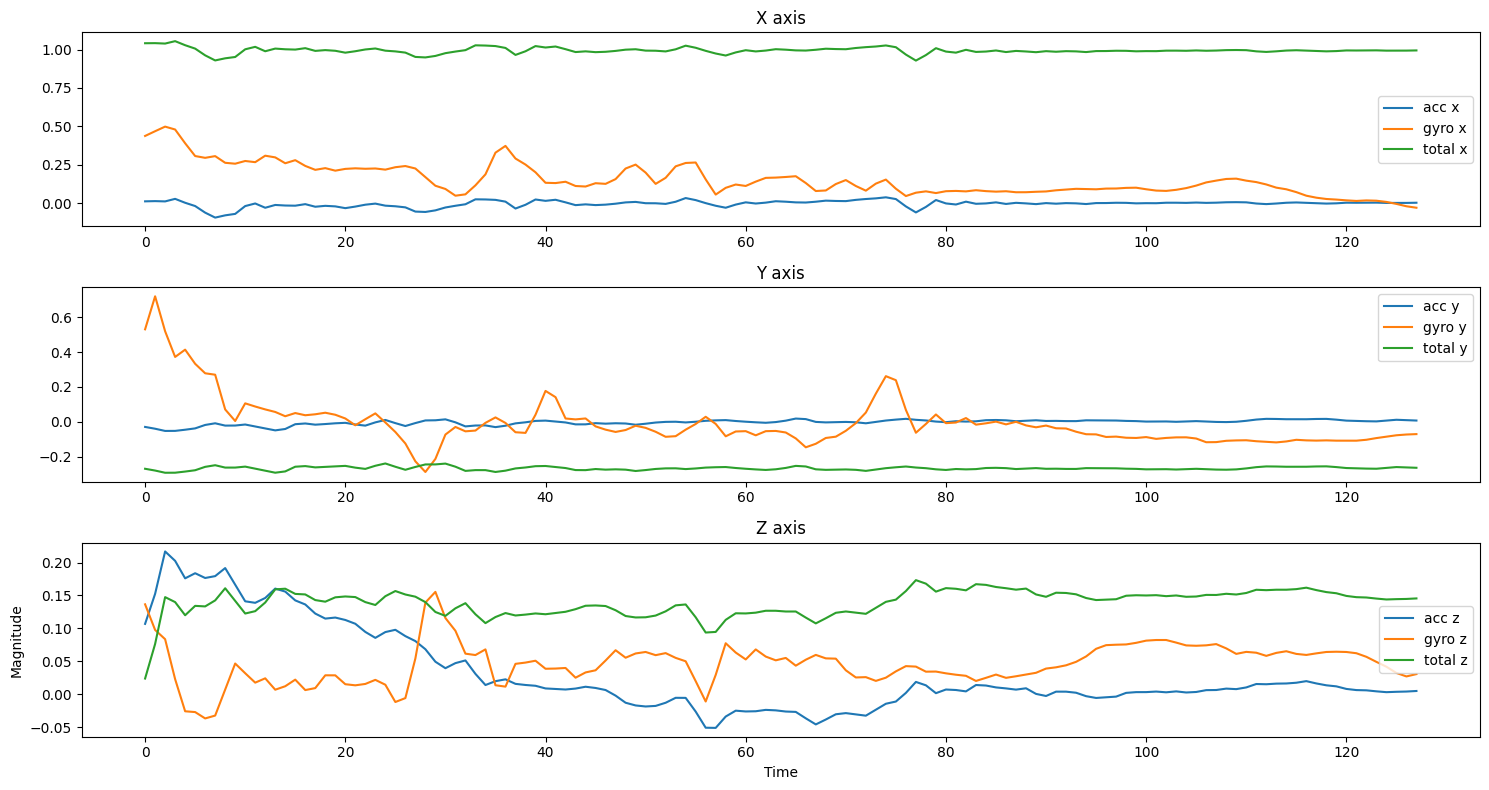

In [6]:
plt.figure(figsize=(15, 8))

r, c = 3, 1
plt.subplot(r, c, 1)
plt.title("X axis")
sns.lineplot(body_acc_x_test[0], label="acc x")
sns.lineplot(body_gyro_x_test[0], label="gyro x")
sns.lineplot(total_acc_x_test[0], label="total x")

plt.subplot(r, c, 2)
plt.title("Y axis")
sns.lineplot(body_acc_y_test[0], label="acc y")
sns.lineplot(body_gyro_y_test[0], label="gyro y")
sns.lineplot(total_acc_y_test[0], label="total y")

plt.subplot(r, c, 3)
plt.title("Z axis")
sns.lineplot(body_acc_z_test[0], label="acc z")
sns.lineplot(body_gyro_z_test[0], label="gyro z")
sns.lineplot(total_acc_z_test[0], label="total z")

plt.xlabel("Time")
plt.ylabel("Magnitude")
plt.tight_layout()

In [7]:
train = np.concatenate([
    body_acc_x_train, 
    body_acc_y_train, 
    body_acc_z_train,
    body_gyro_x_train, 
    body_gyro_y_train, 
    body_gyro_z_train,
    total_acc_x_train, 
    total_acc_y_train, 
    total_acc_z_train], axis=1)

test = np.concatenate([
    body_acc_x_test, 
    body_acc_y_test, 
    body_acc_z_test,
    body_gyro_x_test, 
    body_gyro_y_test, 
    body_gyro_z_test,
    total_acc_x_test, 
    total_acc_y_test, 
    total_acc_z_test], axis=1)

In [8]:
train.shape, test.shape

((7352, 1152), (2947, 1152))

In [9]:
_, train_val, _, train_label_val = train_test_split(train, train_labels, test_size=0.2, random_state=42, stratify=train_labels)
_, test_val, _, test_label_val = train_test_split(test, test_labels, test_size=0.2, random_state=42, stratify=test_labels)

## **1. Performance of DL models on RAW Data**

In [10]:
class Data(Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(X)
        self.y = nn.functional.one_hot(torch.Tensor(y.reshape(-1) - 1).type(torch.LongTensor)).type(torch.FloatTensor)
        
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
train_loader = DataLoader(Data(train, train_labels), batch_size=32, shuffle=False)
test_loader = DataLoader(Data(test, test_labels), batch_size=32, shuffle=False)

In [12]:
train_val_loader = DataLoader(Data(train_val, train_label_val), batch_size=32, shuffle=False)
test_val_loader = DataLoader(Data(test_val, test_label_val), batch_size=32, shuffle=False)

### **Bi-LSTM Model**

In [17]:
class BiLSTM_Model(L.LightningModule):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(2 * hidden_dim, output_dim)
        self.act = nn.Tanh()

        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.act(self.fc(x))
        return x 

    def training_step(self, train_batch):
        x, y = train_batch
        pred = self.forward(x)
        loss = self.criterion(pred, y)
        self.log("Train Loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, val_batch):
        x, y = val_batch
        pred = self.forward(x)
        loss = self.criterion(pred, y)
        self.log("Val Loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=0.005, weight_decay=1e-6)
        return optimizer


In [18]:
early_stop_callback = EarlyStopping(monitor="Val Loss", min_delta=0.00, patience=10, verbose=False, mode="min")
checkpoint_callback = ModelCheckpoint(monitor='Val Loss',  mode="min")

input_dim = train.shape[-1]
lstm = BiLSTM_Model(input_dim=input_dim, hidden_dim=50, layer_dim=1, output_dim=6)

trainer = L.Trainer(max_epochs=100, callbacks=[early_stop_callback, checkpoint_callback])
trainer.fit(model=lstm, train_dataloaders=train_loader, val_dataloaders=test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | lstm      | LSTM             | 481 K  | train
1 | fc        | Linear           | 606    | train
2 | act       | Tanh             | 0      | train
3 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
482 K     Trainable params
0         Non-trainable params
482 K     Total params
1.929     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\kaush\miniconda3\envs\pt\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [19]:
torch.save(lstm, "models/BiLSTM.pt")

In [20]:
true, pred = [], []
lstm.eval()
with torch.no_grad():
    for X, y in test_loader:
        pred.append(lstm(X))
        true.append(y)

In [21]:
flattened_true = list(itertools.chain.from_iterable([torch.argmax(true[i], axis=1).flatten().tolist() for i in range(len(true))]))
values_true = [mappings[i] for i in flattened_true]
flattened_pred = list(itertools.chain.from_iterable([torch.argmax(pred[i], axis=1).flatten().tolist() for i in range(len(pred))]))
values_pred = [mappings[i] for i in flattened_pred]

In [22]:
len(values_pred), len(values_true)

(2947, 2947)

In [23]:
print(classification_report(values_pred, values_true))

                    precision    recall  f1-score   support

            LAYING       0.94      1.00      0.97       503
           SITTING       0.87      0.96      0.91       442
          STANDING       0.97      0.87      0.91       594
           WALKING       0.93      0.97      0.95       475
WALKING_DOWNSTAIRS       0.95      0.91      0.93       434
  WALKING_UPSTAIRS       0.95      0.89      0.92       499

          accuracy                           0.93      2947
         macro avg       0.93      0.93      0.93      2947
      weighted avg       0.93      0.93      0.93      2947



In [24]:
mappings

{0: 'WALKING',
 1: 'WALKING_UPSTAIRS',
 2: 'WALKING_DOWNSTAIRS',
 3: 'SITTING',
 4: 'STANDING',
 5: 'LAYING'}

<Axes: >

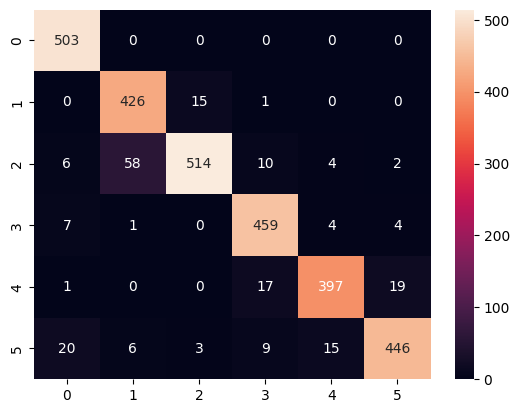

In [25]:
cm = confusion_matrix(values_pred, values_true)
sns.heatmap(cm, annot=True, fmt="")

### **1D-CNN Model**

In [26]:
class CNN_Model(L.LightningModule):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(1, hidden_dim, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.fc = nn.Linear(hidden_dim, output_dim)

        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.cnn(x)
        x = x.squeeze(-1)
        x = self.fc(x)
        return x 

    def training_step(self, train_batch):
        x, y = train_batch
        pred = self.forward(x)
        loss = self.criterion(pred, y)
        self.log("Train Loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, val_batch):
        x, y = val_batch
        pred = self.forward(x)
        loss = self.criterion(pred, y)
        self.log("Val Loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=0.005, weight_decay=1e-6)
        return optimizer

In [27]:
next(iter(train_loader))[0].shape

torch.Size([32, 1152])

In [28]:
early_stop_callback = EarlyStopping(monitor="Val Loss", min_delta=0.00, patience=10, verbose=False, mode="min")
checkpoint_callback = ModelCheckpoint(monitor='Val Loss',  mode="min")

input_dim = train.shape[-1]
cnn = CNN_Model(input_dim=input_dim, hidden_dim=64, output_dim=6)

trainer = L.Trainer(max_epochs=100, callbacks=[early_stop_callback, checkpoint_callback])
trainer.fit(model=cnn, train_dataloaders=train_loader, val_dataloaders=test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | cnn       | Sequential       | 12.6 K | train
1 | fc        | Linear           | 390    | train
2 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
13.0 K    Trainable params
0         Non-trainable params
13.0 K    Total params
0.052     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\kaush\miniconda3\envs\pt\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\kaush\miniconda3\envs\pt\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [29]:
torch.save(cnn, "models/cnn.pt")

In [30]:
true, pred = [], []
cnn.eval()
with torch.no_grad():
    for X, y in test_loader:
        pred.append(cnn(X))
        true.append(y)

In [31]:
flattened_true = list(itertools.chain.from_iterable([torch.argmax(true[i], axis=1).flatten().tolist() for i in range(len(true))]))
values_true = [mappings[i] for i in flattened_true]
flattened_pred = list(itertools.chain.from_iterable([torch.argmax(pred[i], axis=1).flatten().tolist() for i in range(len(pred))]))
values_pred = [mappings[i] for i in flattened_pred]

In [32]:
print(classification_report(values_pred, values_true))

                    precision    recall  f1-score   support

            LAYING       0.76      0.84      0.80       485
           SITTING       0.49      0.63      0.55       378
          STANDING       0.85      0.65      0.74       691
           WALKING       0.98      0.78      0.87       625
WALKING_DOWNSTAIRS       0.79      0.93      0.85       359
  WALKING_UPSTAIRS       0.78      0.90      0.83       409

          accuracy                           0.78      2947
         macro avg       0.77      0.79      0.77      2947
      weighted avg       0.80      0.78      0.78      2947



In [33]:
mappings

{0: 'WALKING',
 1: 'WALKING_UPSTAIRS',
 2: 'WALKING_DOWNSTAIRS',
 3: 'SITTING',
 4: 'STANDING',
 5: 'LAYING'}

<Axes: >

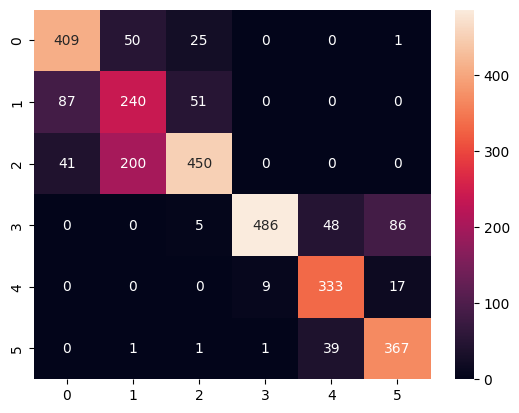

In [34]:
cm = confusion_matrix(values_pred, values_true)
sns.heatmap(cm, annot=True, fmt="")

## **2. Performance of ML-DL models after Feature Extraction**

### **Feature Extraction**

In [35]:
import os
import tsfel
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold

def preprocess(train: list, test: list, name: str, fs=100):
    cfg = tsfel.get_features_by_domain()
    train = tsfel.time_series_features_extractor(cfg, train, fs=fs)
    test = tsfel.time_series_features_extractor(cfg, test, fs=fs)

    corr_features, train = tsfel.correlated_features(train, drop_correlated=True)
    test.drop(corr_features, axis=1, inplace=True)

    selector = VarianceThreshold()
    train = selector.fit_transform(train)
    test = selector.transform(test)

    # Normalizing Features
    scaler = preprocessing.StandardScaler()
    train = scaler.fit_transform(train)
    test = scaler.transform(test)
    
    np.save(f"data/preprocessed/{name}-train.npy", train)
    np.save(f"data/preprocessed/{name}-test.npy", test)


In [ ]:
preprocess(body_acc_x_train, body_acc_x_test, name="body_acc_x")
preprocess(body_acc_y_train, body_acc_y_test, name="body_acc_y")
preprocess(body_acc_z_train, body_acc_z_test, name="body_acc_z")
preprocess(body_gyro_x_train, body_gyro_x_test, name="body_gyro_x")
preprocess(body_gyro_y_train, body_gyro_y_test, name="body_gyro_y")
preprocess(body_gyro_z_train, body_gyro_z_test, name="body_gyro_z")
preprocess(total_acc_x_train, total_acc_x_test, name="total_acc_x")
preprocess(total_acc_y_train, total_acc_y_test, name="total_acc_y")
preprocess(total_acc_z_train, total_acc_z_test, name="total_acc_z")

(7352, 83) (2947, 83)


(7352, 88) (2947, 88)


(7352, 93) (2947, 93)


(7352, 92) (2947, 92)


(7352, 93) (2947, 93)


(7352, 93) (2947, 93)


(7352, 80) (2947, 80)


(7352, 81) (2947, 81)


(7352, 86) (2947, 86)


In [36]:
import gc
gc.collect()

15187

In [105]:
body_acc_x_train = np.load("data/preprocessed/body_acc_x-train.npy")
body_acc_y_train = np.load("data/preprocessed/body_acc_y-train.npy")
body_acc_z_train = np.load("data/preprocessed/body_acc_z-train.npy")
body_gyro_x_train = np.load("data/preprocessed/body_gyro_x-train.npy")
body_gyro_y_train = np.load("data/preprocessed/body_gyro_y-train.npy")
body_gyro_z_train = np.load("data/preprocessed/body_gyro_z-train.npy")
total_acc_x_train = np.load("data/preprocessed/total_acc_x-train.npy")
total_acc_y_train = np.load("data/preprocessed/total_acc_y-train.npy")
total_acc_z_train = np.load("data/preprocessed/total_acc_z-train.npy")

body_acc_x_test = np.load("data/preprocessed/body_acc_x-test.npy")
body_acc_y_test = np.load("data/preprocessed/body_acc_y-test.npy")
body_acc_z_test = np.load("data/preprocessed/body_acc_z-test.npy")
body_gyro_x_test = np.load("data/preprocessed/body_gyro_x-test.npy")
body_gyro_y_test = np.load("data/preprocessed/body_gyro_y-test.npy")
body_gyro_z_test = np.load("data/preprocessed/body_gyro_z-test.npy")
total_acc_x_test = np.load("data/preprocessed/total_acc_x-test.npy")
total_acc_y_test = np.load("data/preprocessed/total_acc_y-test.npy")
total_acc_z_test = np.load("data/preprocessed/total_acc_z-test.npy")

In [106]:
print(total_acc_z_train.shape)
print(total_acc_z_test.shape)

(7352, 86)
(2947, 86)


In [107]:
train = np.concatenate([
    body_acc_x_train, 
    body_acc_y_train, 
    body_acc_z_train,
    body_gyro_x_train, 
    body_gyro_y_train, 
    body_gyro_z_train,
    total_acc_x_train, 
    total_acc_y_train, 
    total_acc_z_train], axis=1)

test = np.concatenate([
    body_acc_x_test, 
    body_acc_y_test, 
    body_acc_z_test,
    body_gyro_x_test, 
    body_gyro_y_test, 
    body_gyro_z_test,
    total_acc_x_test, 
    total_acc_y_test, 
    total_acc_z_test], axis=1)

In [108]:
train.shape, test.shape

((7352, 789), (2947, 789))

In [42]:
train_loader = DataLoader(Data(train, train_labels), batch_size=32, shuffle=False)
test_loader = DataLoader(Data(test, test_labels), batch_size=32, shuffle=False)

### **Bi-LSTM Model**

In [43]:
early_stop_callback = EarlyStopping(monitor="Val Loss", min_delta=0.00, patience=10, verbose=False, mode="min")
checkpoint_callback = ModelCheckpoint(monitor='Val Loss',  mode="min")

input_dim = train.shape[-1]
lstm = BiLSTM_Model(input_dim=input_dim, hidden_dim=50, layer_dim=1, output_dim=6)

trainer = L.Trainer(max_epochs=100, callbacks=[early_stop_callback, checkpoint_callback])
trainer.fit(model=lstm, train_dataloaders=train_loader, val_dataloaders=test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | lstm      | LSTM             | 336 K  | train
1 | fc        | Linear           | 606    | train
2 | act       | Tanh             | 0      | train
3 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
337 K     Trainable params
0         Non-trainable params
337 K     Total params
1.348     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\kaush\miniconda3\envs\pt\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [44]:
true, pred = [], []
lstm.eval()
with torch.no_grad():
    for X, y in test_loader:
        pred.append(lstm(X))
        true.append(y)

In [45]:
flattened_true = list(itertools.chain.from_iterable([torch.argmax(true[i], axis=1).flatten().tolist() for i in range(len(true))]))
values_true = [mappings[i] for i in flattened_true]
flattened_pred = list(itertools.chain.from_iterable([torch.argmax(pred[i], axis=1).flatten().tolist() for i in range(len(pred))]))
values_pred = [mappings[i] for i in flattened_pred]

In [46]:
print(classification_report(values_pred, values_true, zero_division=0))

                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       539
           SITTING       0.98      0.99      0.99       485
          STANDING       0.99      0.99      0.99       536
           WALKING       1.00      1.00      1.00       498
WALKING_DOWNSTAIRS       0.97      1.00      0.98       407
  WALKING_UPSTAIRS       1.00      0.98      0.99       482

          accuracy                           0.99      2947
         macro avg       0.99      0.99      0.99      2947
      weighted avg       0.99      0.99      0.99      2947



<Axes: >

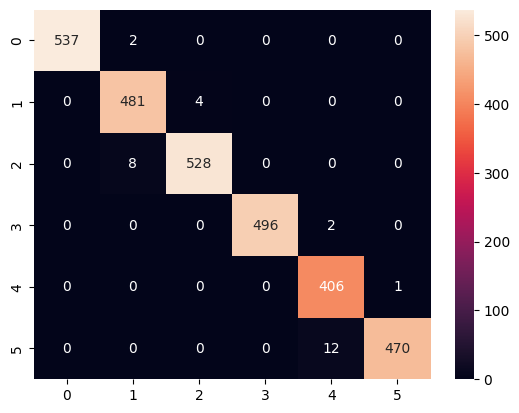

In [47]:
cm = confusion_matrix(values_pred, values_true)
sns.heatmap(cm, annot=True, fmt="")

### **1D-CNN Model**

In [48]:
early_stop_callback = EarlyStopping(monitor="Val Loss", min_delta=0.00, patience=10, verbose=False, mode="min")
checkpoint_callback = ModelCheckpoint(monitor='Val Loss',  mode="min")

input_dim = train.shape[-1]
cnn = CNN_Model(input_dim=input_dim, hidden_dim=64, output_dim=6)

trainer = L.Trainer(max_epochs=100, callbacks=[early_stop_callback, checkpoint_callback])
trainer.fit(model=cnn, train_dataloaders=train_loader, val_dataloaders=test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | cnn       | Sequential       | 12.6 K | train
1 | fc        | Linear           | 390    | train
2 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
13.0 K    Trainable params
0         Non-trainable params
13.0 K    Total params
0.052     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\kaush\miniconda3\envs\pt\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\kaush\miniconda3\envs\pt\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [49]:
true, pred = [], []
cnn.eval()
with torch.no_grad():
    for X, y in test_loader:
        pred.append(cnn(X))
        true.append(y)

In [50]:
flattened_true = list(itertools.chain.from_iterable([torch.argmax(true[i], axis=1).flatten().tolist() for i in range(len(true))]))
values_true = [mappings[i] for i in flattened_true]
flattened_pred = list(itertools.chain.from_iterable([torch.argmax(pred[i], axis=1).flatten().tolist() for i in range(len(pred))]))
values_pred = [mappings[i] for i in flattened_pred]

In [51]:
print(classification_report(values_pred, values_true, zero_division=0))

                    precision    recall  f1-score   support

            LAYING       0.71      0.62      0.67       614
           SITTING       0.60      0.43      0.50       689
          STANDING       0.27      0.58      0.37       251
           WALKING       0.94      0.48      0.63       982
WALKING_DOWNSTAIRS       0.31      0.67      0.43       196
  WALKING_UPSTAIRS       0.41      0.89      0.56       215

          accuracy                           0.55      2947
         macro avg       0.54      0.61      0.53      2947
      weighted avg       0.68      0.55      0.57      2947



<Axes: >

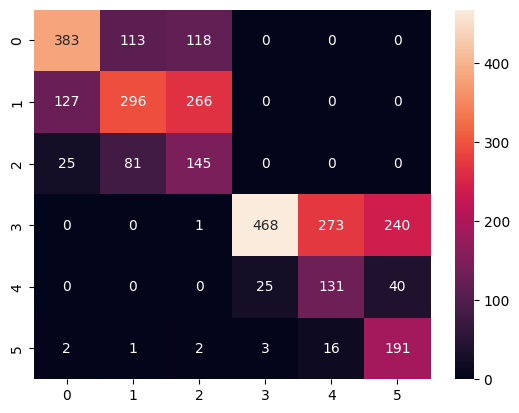

In [52]:
cm = confusion_matrix(values_pred, values_true)
sns.heatmap(cm, annot=True, fmt="")

In [170]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
train_tsne = tsne.fit_transform(train)
test_tsne = tsne.fit_transform(test)

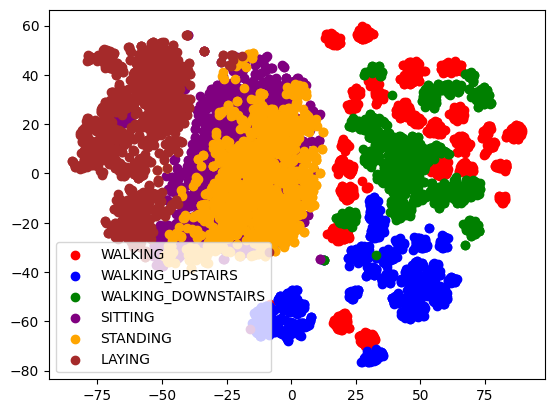

In [171]:
colors = ["red", "blue", "green", "purple", "orange", "brown"]

for i, label in enumerate(np.unique(train_labels-1)):
    idx = train_labels-1 == label
    plt.scatter(train_tsne[idx, 0], train_tsne[idx, 1], label=mappings[label], c=colors[i])

plt.legend()

In [55]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [56]:
test.shape, test_labels.shape

((2947, 789), (2947,))

#### Grid Search

In [57]:
model_params = {
    "rf": {
        "model": RandomForestClassifier(),
        "params": {
            "n_estimators": [10, 50, 100],
            "max_depth": [5, 10, None],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 2, 4],
        },
    },
    "svm": {
        "model": SVC(),
        "params": {
            "C": [0.1, 1, 10, 100],
            "kernel": ["linear", "poly", "rbf", "sigmoid"],  
            "gamma": ["scale", "auto"],  
            "degree": [2, 3, 4], 
            "max_iter": [1000]
        },
    },
    "lr": {
        "model": LogisticRegression(),
        "params": {
            "C": [0.1, 1, 10, 100],  
            "solver": ['liblinear', 'lbfgs']
        },
    },
}

##### No tSNE grid search

In [58]:
import json

if not os.path.isfile("no-tsne-params.json"):
    no_tsne_params = {}
    for name, attributes in model_params.items():
        model = attributes["model"]
        params = attributes["params"]
        
        clf = grid_search = GridSearchCV(model, params, cv=5, scoring='accuracy', n_jobs=-2, verbose=1)
        clf.fit(train_val, train_label_val)

        no_tsne_params[name] = grid_search.best_params_

    with open("no-tsne-params.json", "w") as file:
        json.dump(no_tsne_params, file)

In [59]:
with open("no-tsne-params.json", "r") as file:
    no_tsne_params = json.load(file)
    
with open("tsne-params.json", "r") as file:
    tsne_params = json.load(file)

#### **Random Forest**

In [60]:
rf = RandomForestClassifier()
rf.set_params(**no_tsne_params["rf"])
rf.fit(train, train_labels-1)

RandomForestClassifier(min_samples_leaf=2, min_samples_split=5)

In [61]:
pred = rf.predict(test)

In [62]:
print(classification_report(pred, test_labels-1))

              precision    recall  f1-score   support

         0.0       0.99      0.96      0.97       513
         1.0       0.98      0.93      0.95       497
         2.0       0.87      0.97      0.91       378
         3.0       0.90      0.95      0.93       465
         4.0       0.96      0.92      0.94       557
         5.0       1.00      1.00      1.00       537

    accuracy                           0.95      2947
   macro avg       0.95      0.95      0.95      2947
weighted avg       0.95      0.95      0.95      2947



<Axes: >

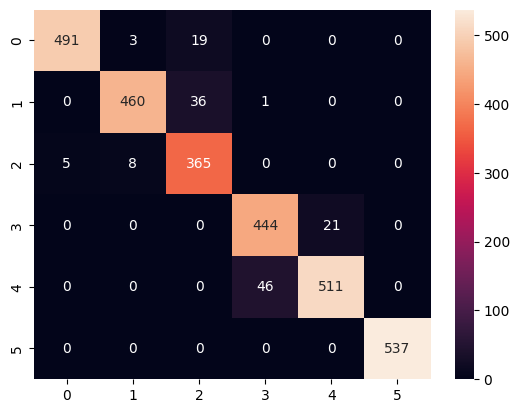

In [63]:
cm = confusion_matrix(pred, test_labels-1)
sns.heatmap(cm, annot=True, fmt="")

#### **Support Vector Machine**

In [64]:
svm = SVC()
svm.set_params(**no_tsne_params["svm"])
svm.fit(train, train_labels-1)

c:\Users\kaush\miniconda3\envs\pt\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVC(C=0.1, degree=2, kernel='linear', max_iter=1000)

In [65]:
pred = svm.predict(test)
print(classification_report(pred, test_labels-1))

              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97       518
         1.0       0.95      0.98      0.97       455
         2.0       0.98      0.99      0.98       415
         3.0       0.85      0.92      0.89       453
         4.0       0.94      0.88      0.90       569
         5.0       1.00      1.00      1.00       537

    accuracy                           0.95      2947
   macro avg       0.95      0.95      0.95      2947
weighted avg       0.95      0.95      0.95      2947



<Axes: >

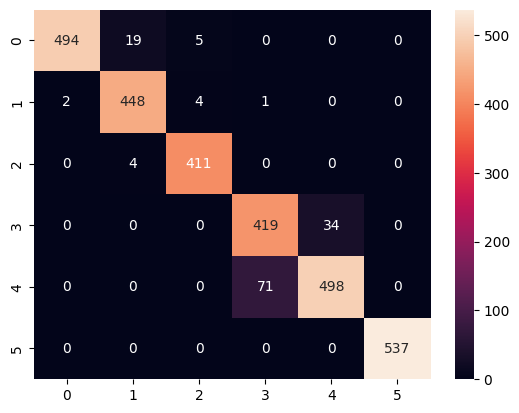

In [66]:
cm = confusion_matrix(pred, test_labels-1)
sns.heatmap(cm, annot=True, fmt="")

#### **Logistic Regression**

In [67]:
lr = LogisticRegression()
lr.set_params(**no_tsne_params["lr"])
lr.fit(train, train_labels-1)

LogisticRegression(C=1, solver='liblinear')

In [68]:
pred = lr.predict(test)
print(classification_report(pred, test_labels-1))

              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98       508
         1.0       0.97      0.98      0.98       468
         2.0       0.97      0.99      0.98       410
         3.0       0.85      0.93      0.89       451
         4.0       0.94      0.85      0.89       586
         5.0       0.97      0.99      0.98       524

    accuracy                           0.95      2947
   macro avg       0.95      0.95      0.95      2947
weighted avg       0.95      0.95      0.95      2947



<Axes: >

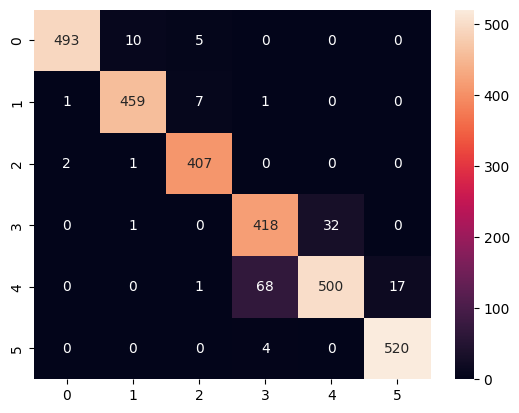

In [69]:
cm = confusion_matrix(pred, test_labels-1)
sns.heatmap(cm, annot=True, fmt="")

## **3. Comparison with provided features**

In [70]:
provided_train = np.loadtxt("data\\UCI HAR Dataset\\UCI HAR Dataset\\train\\X_train.txt")
provided_train_labels = np.loadtxt("data\\UCI HAR Dataset\\UCI HAR Dataset\\train\\y_train.txt")
provided_test = np.loadtxt("data\\UCI HAR Dataset\\UCI HAR Dataset\\test\\X_test.txt")
provided_test_labels = np.loadtxt("data\\UCI HAR Dataset\\UCI HAR Dataset\\test\\y_test.txt")

In [71]:
train_loader = DataLoader(Data(provided_train, provided_train_labels), batch_size=32, shuffle=False)
test_loader = DataLoader(Data(provided_test, provided_test_labels), batch_size=32, shuffle=False)

In [72]:
next(iter(train_loader))[0].shape

torch.Size([32, 561])

In [151]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
provided_train_tsne = tsne.fit_transform(provided_train)
provided_test_tsne = tsne.fit_transform(provided_test)

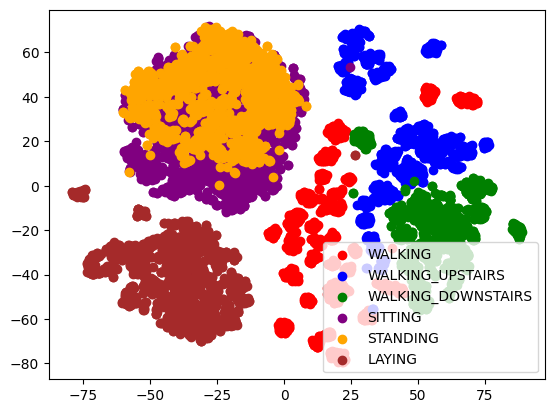

In [169]:
colors = ["red", "blue", "green", "purple", "orange", "brown"]

for i, label in enumerate(np.unique(provided_train_labels-1)):
    idx = (provided_train_labels-1 == label).astype(bool)
    plt.scatter(provided_train_tsne[idx, 0], provided_train_tsne[idx, 1], label=mappings[label], c=colors[i])

plt.legend()

### **BiLSTM Model**

In [73]:
early_stop_callback = EarlyStopping(monitor="Val Loss", min_delta=0.00, patience=10, verbose=False, mode="min")
checkpoint_callback = ModelCheckpoint(monitor='Val Loss',  mode="min")

input_dim = provided_train.shape[-1]
lstm = BiLSTM_Model(input_dim=input_dim, hidden_dim=50, layer_dim=1, output_dim=6)

trainer = L.Trainer(max_epochs=100, callbacks=[early_stop_callback, checkpoint_callback])
trainer.fit(model=lstm, train_dataloaders=train_loader, val_dataloaders=test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | lstm      | LSTM             | 245 K  | train
1 | fc        | Linear           | 606    | train
2 | act       | Tanh             | 0      | train
3 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
245 K     Trainable params
0         Non-trainable params
245 K     Total params
0.983     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\kaush\miniconda3\envs\pt\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\kaush\miniconda3\envs\pt\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [74]:
torch.save(lstm, "models/provided_BiLSTM.pt")

In [75]:
true, pred = [], []
lstm.eval()
with torch.no_grad():
    for X, y in test_loader:
        pred.append(lstm(X))
        true.append(y)

In [76]:
flattened_true = list(itertools.chain.from_iterable([torch.argmax(true[i], axis=1).flatten().tolist() for i in range(len(true))]))
values_true = [mappings[i] for i in flattened_true]
flattened_pred = list(itertools.chain.from_iterable([torch.argmax(pred[i], axis=1).flatten().tolist() for i in range(len(pred))]))
values_pred = [mappings[i] for i in flattened_pred]

In [77]:
print(classification_report(values_pred, values_true))

                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       539
           SITTING       0.96      0.93      0.95       504
          STANDING       0.94      0.97      0.95       516
           WALKING       0.96      0.98      0.97       487
WALKING_DOWNSTAIRS       0.98      0.80      0.88       518
  WALKING_UPSTAIRS       0.80      0.98      0.88       383

          accuracy                           0.94      2947
         macro avg       0.94      0.94      0.94      2947
      weighted avg       0.95      0.94      0.94      2947



In [78]:
mappings

{0: 'WALKING',
 1: 'WALKING_UPSTAIRS',
 2: 'WALKING_DOWNSTAIRS',
 3: 'SITTING',
 4: 'STANDING',
 5: 'LAYING'}

<Axes: >

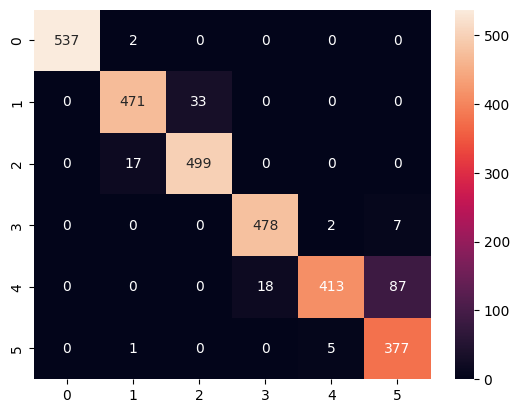

In [79]:
cm = confusion_matrix(values_pred, values_true)
sns.heatmap(cm, annot=True, fmt="")

### **CNN Model**

In [80]:
early_stop_callback = EarlyStopping(monitor="Val Loss", min_delta=0.00, patience=10, verbose=False, mode="min")
checkpoint_callback = ModelCheckpoint(monitor='Val Loss',  mode="min")

input_dim = provided_train.shape[-1]
cnn = CNN_Model(input_dim=input_dim, hidden_dim=64, output_dim=6)

trainer = L.Trainer(max_epochs=100, callbacks=[early_stop_callback, checkpoint_callback])
trainer.fit(model=cnn, train_dataloaders=train_loader, val_dataloaders=test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | cnn       | Sequential       | 12.6 K | train
1 | fc        | Linear           | 390    | train
2 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
13.0 K    Trainable params
0         Non-trainable params
13.0 K    Total params
0.052     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\kaush\miniconda3\envs\pt\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\kaush\miniconda3\envs\pt\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [81]:
torch.save(cnn, "models/provided_cnn.pt")

In [82]:
true, pred = [], []
cnn.eval()
with torch.no_grad():
    for X, y in test_loader:
        pred.append(cnn(X))
        true.append(y)

In [83]:
flattened_true = list(itertools.chain.from_iterable([torch.argmax(true[i], axis=1).flatten().tolist() for i in range(len(true))]))
values_true = [mappings[i] for i in flattened_true]
flattened_pred = list(itertools.chain.from_iterable([torch.argmax(pred[i], axis=1).flatten().tolist() for i in range(len(pred))]))
values_pred = [mappings[i] for i in flattened_pred]

In [84]:
print(classification_report(values_pred, values_true, zero_division=0))

                    precision    recall  f1-score   support

            LAYING       0.96      0.98      0.97       526
           SITTING       0.68      0.83      0.75       400
          STANDING       0.90      0.76      0.82       633
           WALKING       0.67      0.95      0.79       352
WALKING_DOWNSTAIRS       0.96      0.57      0.71       715
  WALKING_UPSTAIRS       0.65      0.96      0.78       321

          accuracy                           0.80      2947
         macro avg       0.80      0.84      0.80      2947
      weighted avg       0.84      0.80      0.80      2947



In [85]:
mappings

{0: 'WALKING',
 1: 'WALKING_UPSTAIRS',
 2: 'WALKING_DOWNSTAIRS',
 3: 'SITTING',
 4: 'STANDING',
 5: 'LAYING'}

<Axes: >

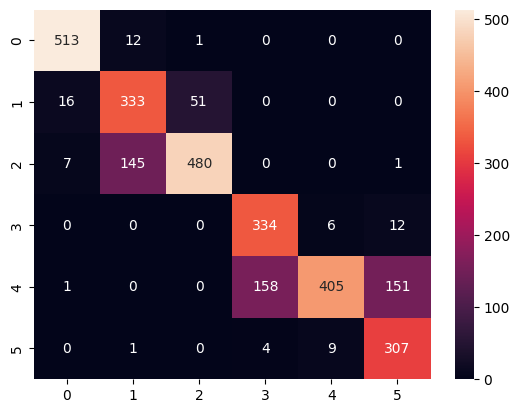

In [86]:
cm = confusion_matrix(values_pred, values_true)
sns.heatmap(cm, annot=True, fmt="")

#### **Random Forest**

In [95]:
rf = RandomForestClassifier()
rf.set_params(**no_tsne_params["rf"])
rf.fit(provided_train, provided_train_labels-1)

RandomForestClassifier(min_samples_leaf=2, min_samples_split=5)

In [97]:
pred = rf.predict(provided_test)

In [100]:
print(classification_report(pred, provided_test_labels-1))

              precision    recall  f1-score   support

         0.0       0.98      0.90      0.94       539
         1.0       0.92      0.91      0.91       477
         2.0       0.85      0.96      0.90       371
         3.0       0.89      0.92      0.90       478
         4.0       0.92      0.90      0.91       545
         5.0       1.00      1.00      1.00       537

    accuracy                           0.93      2947
   macro avg       0.93      0.93      0.93      2947
weighted avg       0.93      0.93      0.93      2947



<Axes: >

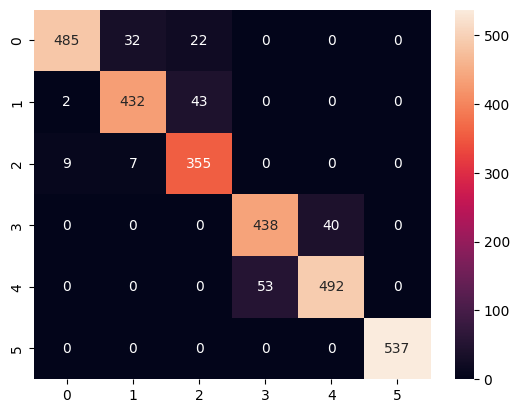

In [99]:
cm = confusion_matrix(pred, provided_test_labels-1)
sns.heatmap(cm, annot=True, fmt="")

####

#### **Support Vector Machine**

In [89]:
svm = SVC()
svm.set_params(**no_tsne_params["svm"])
svm.fit(provided_train, provided_train_labels-1)

c:\Users\kaush\miniconda3\envs\pt\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVC(C=0.1, degree=2, kernel='linear', max_iter=1000)

In [91]:
pred = svm.predict(provided_test)
print(classification_report(pred, provided_test_labels-1))

              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97       521
         1.0       0.95      0.97      0.96       462
         2.0       0.95      0.99      0.97       406
         3.0       0.90      0.96      0.93       459
         4.0       0.97      0.91      0.94       562
         5.0       1.00      1.00      1.00       537

    accuracy                           0.96      2947
   macro avg       0.96      0.96      0.96      2947
weighted avg       0.96      0.96      0.96      2947



In [92]:
mappings

{0: 'WALKING',
 1: 'WALKING_UPSTAIRS',
 2: 'WALKING_DOWNSTAIRS',
 3: 'SITTING',
 4: 'STANDING',
 5: 'LAYING'}

<Axes: >

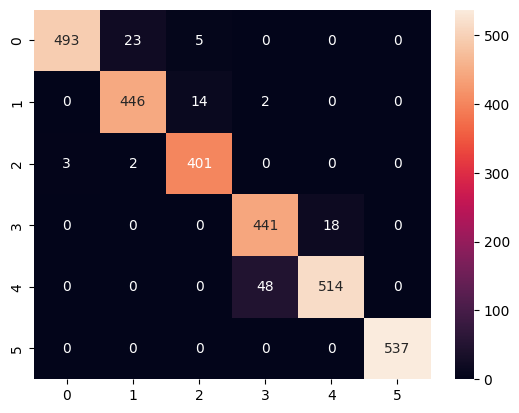

In [94]:
cm = confusion_matrix(pred, provided_test_labels-1)
sns.heatmap(cm, annot=True, fmt="")

#### **Logistic Regression**

In [102]:
lr = LogisticRegression()
lr.set_params(**no_tsne_params["lr"])
lr.fit(provided_train, provided_train_labels-1)

LogisticRegression(C=1, solver='liblinear')

In [103]:
pred = lr.predict(provided_test)
print(classification_report(pred, provided_test_labels-1))

              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97       523
         1.0       0.95      0.97      0.96       461
         2.0       0.97      1.00      0.98       409
         3.0       0.88      0.97      0.92       445
         4.0       0.97      0.90      0.94       572
         5.0       1.00      1.00      1.00       537

    accuracy                           0.96      2947
   macro avg       0.96      0.96      0.96      2947
weighted avg       0.96      0.96      0.96      2947



<Axes: >

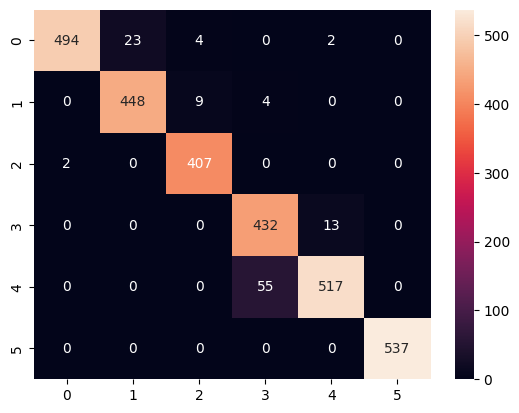

In [104]:
cm = confusion_matrix(pred, provided_test_labels-1)
sns.heatmap(cm, annot=True, fmt="")